In [1]:
from __future__ import division, print_function

import copy
import os
import random
import shutil
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

from cub_dataloader_good import CUB, denormalize, normalize, visualize

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [2]:
data = './CUB_200_2011/'
num_classes = 200
num_epochs = 30

feature_extract = True

batch_size = 8

In [3]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


In [4]:
# Load the pretrained model
model = models.resnet101(pretrained=True)

# # Use the model object to select the desired layer
# layer = model._modules.get('avgpool')

# Set the model to evaluation mode
model.eval()

/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
def normalize():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

def show_image(img):
  img = img.transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)

In [6]:
# Define the image transformations - normalization based on ImageNet parameters
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    normalize(),
    transforms.ToTensor(),
])

In [7]:
PATH = Path('./CUB_200_2011/CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [8]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
train_test.head(2)

,id,is_train
0,1,0
1,2,1


In [9]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [10]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [11]:
categories = [x for x in classes["class"]]

In [12]:
from pathlib import Path

PATH = Path('./CUB_200_2011/CUB_200_2011')

train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform= False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=4)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

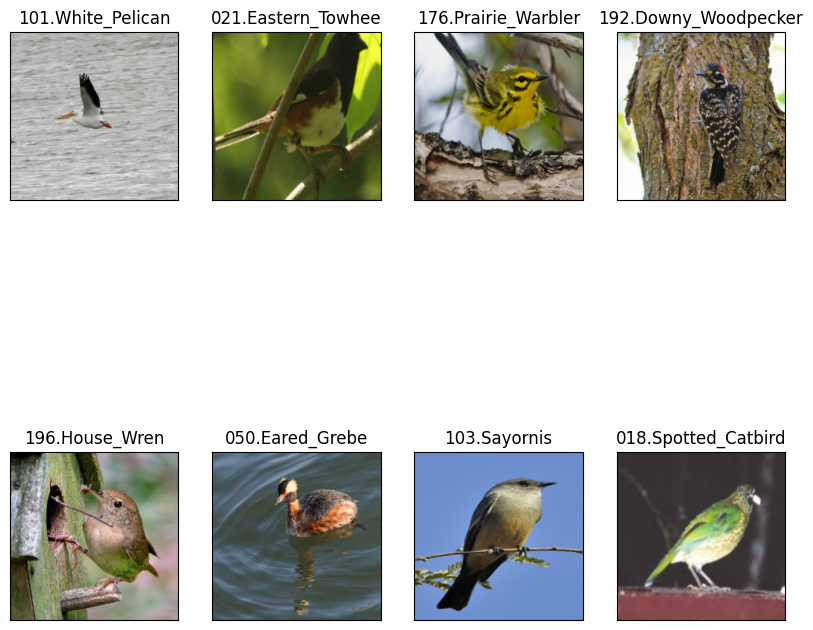

In [13]:
visualize(train_loader, categories)

Image: tensor([[[-0.3369, -0.2856, -0.2684,  ...,  0.1597,  0.1597,  0.1768],
         [-0.3541, -0.3027, -0.2684,  ...,  0.1597,  0.1597,  0.1597],
         [-0.3198, -0.2684, -0.2856,  ...,  0.1597,  0.1597,  0.1597],
         ...,
         [ 0.0398,  0.0569,  0.0741,  ...,  0.2111,  0.0398,  0.0398],
         [ 0.0569,  0.0056,  0.0056,  ...,  0.0569,  0.0569,  0.0398],
         [ 0.0227, -0.0116,  0.0056,  ...,  0.0398,  0.0741,  0.0398]],

        [[ 1.2031,  1.2206,  1.1856,  ...,  1.7108,  1.7108,  1.7108],
         [ 1.1856,  1.2031,  1.1856,  ...,  1.7283,  1.7283,  1.7283],
         [ 1.2031,  1.1856,  1.1856,  ...,  1.7108,  1.7283,  1.7283],
         ...,
         [ 1.4132,  1.3957,  1.3957,  ...,  1.2731,  1.3081,  1.3081],
         [ 1.3782,  1.3957,  1.4132,  ...,  1.3431,  1.3431,  1.3256],
         [ 1.4132,  1.4307,  1.4132,  ...,  1.3081,  1.3256,  1.3256]],

        [[ 1.9951,  2.0125,  2.0300,  ...,  2.4308,  2.4308,  2.4657],
         [ 2.0125,  2.0300,  2.0300,  

/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mike/anaconda3/envs/aai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class index: 18
Predicted class: 019.Gray_Catbird
Actual class label: 030.Fish_Crow
<class 'torch.Tensor'>
tensor([[-4.2618e+00, -1.4662e+00, -4.4530e-01, -6.5692e-01, -4.4666e-01,
         -3.7534e-01, -3.2625e-01,  3.2471e+00,  1.7720e+00,  1.2736e+00,
          1.2693e+00,  3.2402e+00,  3.6308e+00,  4.6302e+00,  2.6309e+00,
          6.6767e+00,  7.0093e+00,  7.8159e+00,  1.2698e+01,  2.9362e+00,
          8.5059e+00,  9.3771e+00,  8.9014e+00,  1.0638e+01,  6.0960e+00,
         -1.9796e+00, -3.3509e+00, -4.1416e+00, -2.4113e+00, -1.5381e+00,
         -1.1333e+00, -1.8027e+00, -3.1495e+00, -1.3013e+00, -1.5417e-01,
         -2.2633e+00, -6.8720e-01, -2.2708e+00, -2.6905e+00, -5.7438e-01,
          1.0349e+00, -7.3573e-01, -1.5837e+00,  1.8487e+00,  1.1984e+00,
         -1.1018e+00,  3.3509e-02, -5.6825e-01, -5.1108e-01, -1.2506e+00,
         -1.1504e+00,  8.1204e-01, -1.5398e+00, -2.3894e+00, -9.4706e-01,
         -2.7862e-01, -3.7717e+00, -4.0541e+00, -1.2414e+00,  1.8141e

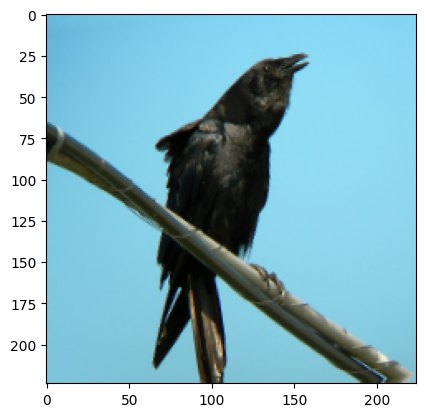

In [19]:
x, y = next(iter(train_loader))
single_image = x[0]
single_label = y[0]

print(f"Image: {single_image}")
print(f"Image shape: {single_image.shape}")
print(f"Label: {single_label}")

inp = single_image.numpy().transpose(1,2,0)
inp = denormalize(inp)
plt.imshow(inp)

# Load the pretrained model
model = models.resnet101(pretrained=True)

single_image.unsqueeze_(0)

# Make sure the image tensor is on the same device as the model
single_image = single_image.to(next(model.parameters()).device)

# Make sure image dtype is the same as model's expected input
single_image = single_image.float()

# Set the model to evaluation mode
model.eval()

# Apply the model to the image
output = model(single_image)

# Get the index corresponding to the maximum score and the maximum score itself.
_, pred = torch.max(output.data, 1)
print(f"Predicted class index: {pred.item()}")
print(f"Predicted class: {categories[pred.item()]}")
print(f"Actual class label: {categories[single_label]}")

print(type(output))
print(output)
print(output.data.shape)

In [ ]:
# Implement SE-GZSL networks
# Implement semantic encoder
def make_semantic_encoder():
    return nn.Sequential(
        nn.Linear(1000, 4096),
        nn.LeakyReLU(0.02)
    )

# Implement generator
def make_generator():
    return nn.Sequential(
        nn.Linear(1000, 4096),
        nn.ReLU(),
    )

# Implement critic
def make_critic():
    return nn.Sequential(
        nn.Linear(4096, 1),
        nn.Sigmoid()
    )


